In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano
import warnings
from numpy.random import binomial, randn, uniform
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%matplotlib inline

sns.set()
warnings.filterwarnings('ignore')

Generate data from
$$y = \alpha_{c} + \beta_{c} \cdot x + \sigma \cdot \epsilon$$

where $\epsilon \sim N(0,1)$ and $c \in \{0,1\}$
$$c \sim Binomial(1,\frac{1}{2})$$
let $\alpha_0 = 1, \alpha_1 = 1.25, \beta_0 = 1, \beta_1 = 1.25 \;$ and $\;\sigma = 0.75$

In [6]:
a0 ,a1, b0 , b1 , sigma = 1, 1.25, 1, 1.25, 0.75

,y,x,category
0,11.530709,8.158420,1
1,6.200481,4.421348,1
2,9.692086,6.011594,1
3,1.300071,0.507125,0
4,2.953093,1.695519,0


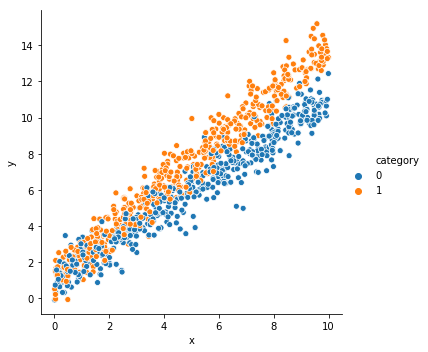

In [7]:
n_samples = 1000

category = binomial(n=1, p=0.5, size=n_samples)
x = uniform(low=0, high=10, size=n_samples)

y = ((1 - category) * a0 + category * a1 + ((1 - category) * b0 + category * b1) * x + sigma * randn(n_samples))

model_data = pd.DataFrame({'y': y, 'x': x, 'category': category})

display(model_data.head())
if sns.__version__ == '0.9.0':
    sns.relplot(x='x', y='y', hue='category', data=model_data)
else:
    print('need update seaborn >= 0.9.0')

pymc need transform datatype to theano

In [8]:
y_tensor = theano.shared(model_data.y.values.astype('float64'))
x_tensor = theano.shared(model_data.x.values.astype('float64'))
cat_tensor = theano.shared(model_data.category.values.astype('int32'))

prior setting
$$y_i \sim N(\mu_i,\sigma^2) \\
\mu_i =  \alpha_c + \beta_c \cdot x_i \\
\alpha_0 \sim N(2,2^2) \\
\alpha_1 \sim N(2,2^2) \\
\beta_0 \sim N(2,2^2) \\
\beta_1 \sim N(2,2^2) \\
\sigma \sim |Cauchy(2)|$$

In [9]:
with pm.Model() as model:
    a_prior = pm.Normal('a', mu=0, sd=2, shape=2)
    b_prior = pm.Normal('b', mu=0, sd=2, shape=2)
    sigma_prior = pm.HalfCauchy('sigma',beta=2, shape=1)
    u_likelihood = a_prior[cat_tensor] + b_prior[cat_tensor] * x_tensor
    y_likelihood = pm.Normal('y', mu=u_likelihood, sd=sigma_prior, observed=y_tensor)

# MCMC sampling with No U-Turn Sampler (NUTS) 

In [10]:
%%time
iterations = 5000
with model:
    start = pm.find_MAP()
    step = pm.NUTS()
    nuts_trace = pm.sample(iterations, step, start,random_seed = 0)

C:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1,128.3, ||grad|| = 0.042169: 100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 908.58it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 22000/22000 [00:23<00:00, 922.32draws/s]


Wall time: 41.8 s


Summary the result

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a__0,0.981642,0.066740,0.000583,0.847443,1.110393,11568.177126,1.000122
a__1,1.130433,0.065846,0.000603,1.006063,1.264284,11623.502826,1.000064
b__0,1.004352,0.011456,0.000098,0.981279,1.026380,11311.172863,1.000127
b__1,1.270935,0.011967,0.000108,1.248820,1.295124,11883.324090,1.000044
sigma__0,0.744081,0.016519,0.000128,0.711883,0.776952,16369.016580,1.000027


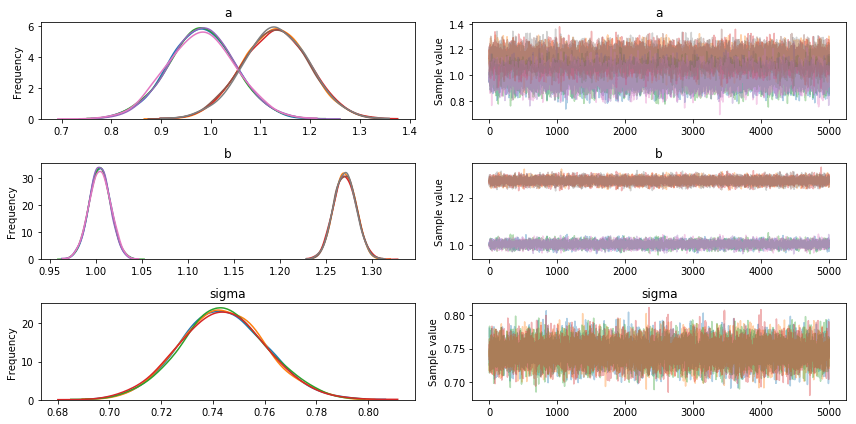

In [11]:
pm.traceplot(nuts_trace)
pm.summary(nuts_trace)

# Variational inference using ADVI

ADVI support minibatch so we use batches of 100 samples

In [12]:
map_tensor_batch = {y_tensor: pm.Minibatch(model_data.y.values, 100),
                    x_tensor: pm.Minibatch(model_data.x.values, 100),
                    cat_tensor: pm.Minibatch(model_data.category.values, 100)}

C:\ProgramData\Anaconda3\lib\site-packages\pymc3\data.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\data.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [13]:
%%time
with model:
    advi_fit = pm.fit(method=pm.ADVI(), n=30000, more_replacements=map_tensor_batch)    

Average Loss = 131.42: 100%|███████████████████████████████████████████████████| 30000/30000 [00:17<00:00, 1723.37it/s]
Finished [100%]: Average Loss = 131.43


Wall time: 22 s


See the ELBO plot to confirm convergence

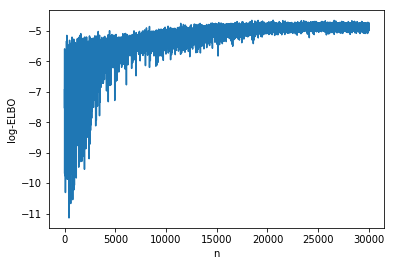

In [14]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

Plot the result

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a__0,0.970643,0.124043,0.001220,0.726377,1.214456
a__1,1.123129,0.126202,0.001150,0.878810,1.374472
b__0,1.004853,0.021990,0.000210,0.964056,1.049887
b__1,1.269478,0.022941,0.000218,1.225055,1.314619
sigma__0,0.770631,0.061149,0.000609,0.655633,0.894358


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DA6C1C1160>,
      dtype=object)

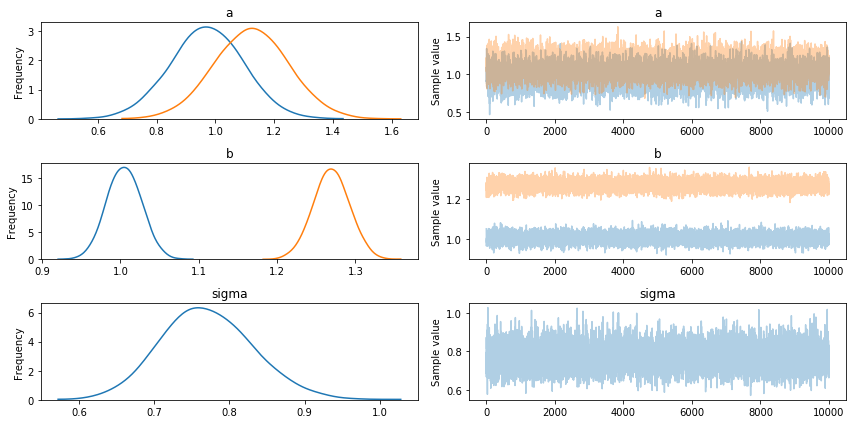

In [15]:
advi_trace = advi_fit.sample(10000)
display(pm.summary(advi_trace))
pm.traceplot(advi_trace)